In [168]:
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import numpy as np

In [169]:
class KANLayer(nn.Module):
    def __init__(self, in_dim, out_dim, num_intervals, spline_order):
        super(KANLayer, self).__init__()

        self.in_dim = in_dim
        self.out_dim = out_dim

        self.num_intervals = num_intervals
        self.spline_order = spline_order
        
        initial_domain = [-1, 1]
        num_control_points = num_intervals + spline_order
        variance = 0.1

        # Parameters for in_dim * out_dim activation functions
        # Initialize control points for all activations
        self.control_points = nn.Parameter(torch.as_tensor(np.random.normal(0, variance, (in_dim, out_dim, num_control_points))), requires_grad=True)

        # Initialize grid per activation function
        grid = torch.linspace(initial_domain[0], initial_domain[1], num_intervals + 1)
        step_size = (initial_domain[1] - initial_domain[0]) / num_intervals

        pre_padding = torch.linspace(initial_domain[0] - spline_order * step_size, initial_domain[0] - step_size, spline_order)
        post_padding = torch.linspace(initial_domain[1] + step_size, initial_domain[1] + spline_order * step_size, spline_order)
        extended_grid = torch.cat((pre_padding, grid, post_padding))

        self.grids = extended_grid.repeat(in_dim * out_dim, 1).reshape(in_dim, out_dim, -1)

        # Residual function silu
        self.silu = nn.SiLU()

        # Initialize weights for the scaling factor with Xavier initialization
        xavier_weights = np.random.normal(0, np.sqrt(2 / out_dim), (in_dim, out_dim))
        self.scaling_factors = nn.Parameter(torch.as_tensor(xavier_weights), requires_grad=True)
        
    def batched_cox_de_boor(self, i, degree, x):
        expanded_x = x.unsqueeze(-1)

        if degree == 0:
            return (self.grids[:, :, i] <= expanded_x) * (expanded_x < self.grids[:, :, i + 1])
        
        left_side = (expanded_x - self.grids[:, :, i]) / (self.grids[:, :, i + degree] - self.grids[:, :, i]) * self.batched_cox_de_boor(i, degree - 1, x)
        right_side = (self.grids[:, :, i + degree + 1] - expanded_x) / (self.grids[:, :, i + degree + 1] - self.grids[:, :, i + 1]) * self.batched_cox_de_boor(i + 1, degree - 1, x)

        return left_side + right_side
    
    def forward(self, x):
        # Compute activations
        result = 0.0
        for i in range(self.num_intervals + self.spline_order):
            result += self.control_points[:, :, i] * self.batched_cox_de_boor(i, self.spline_order, x)

        # Add residual connection and scaling
        res_x = self.silu(x)
        result = self.scaling_factors * (res_x.unsqueeze(-1) + result)

        # Sum results into neurons for next layer
        result = result.reshape(x.shape[0], self.in_dim, self.out_dim)
        result = torch.sum(result, dim=1)

        return result

Epoch 0, loss: 0.35770363641943503
Epoch 100, loss: 0.008098630164338885
Epoch 200, loss: 0.0010535591021621693
Epoch 300, loss: 0.00021817279790223052
Epoch 400, loss: 2.8494906637197377e-05
Epoch 500, loss: 2.3913497032437446e-06
Epoch 600, loss: 1.3617511260159787e-07
Epoch 700, loss: 1.054387939929957e-08
Epoch 800, loss: 6.009622403171744e-09
Epoch 900, loss: 5.905156418463241e-09


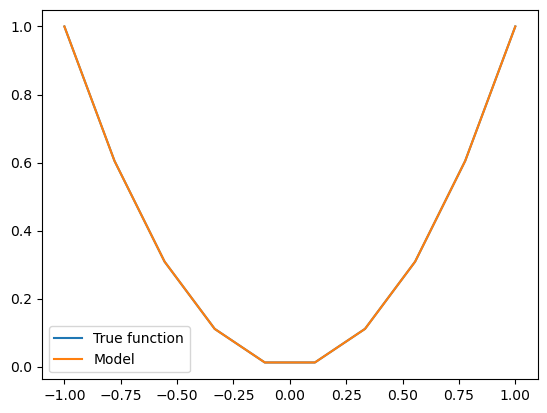

In [170]:
# 1D example
model = KANLayer(1, 1, 5, 2)

opt = torch.optim.Adam(model.parameters(), lr=0.01)

def f(x):
    return x**2

data = torch.linspace(-1, 1, 10)
labels = f(data)

for i in range(1000):
    opt.zero_grad()

    out = model(data)[:, 0]
    loss = (out - labels)**2
    loss = loss.mean()
    loss.backward()
    opt.step()

    if i % 100 == 0:
        print(f"Epoch {i}, loss: {loss.item()}")

plt.plot(data, labels, label="True function")
plt.plot(data, out.detach().numpy(), label="Model")

plt.legend()
plt.show()

Epoch 0, loss: 4.703997569841987
Epoch 100, loss: 0.0771459226541571
Epoch 200, loss: 0.005079517974866409
Epoch 300, loss: 0.0021661670056374494
Epoch 400, loss: 0.0009106443559102069
Epoch 500, loss: 0.0003339940336942959
Epoch 600, loss: 0.00010674807394593355
Epoch 700, loss: 2.9697132049842974e-05
Epoch 800, loss: 7.213105074517802e-06
Epoch 900, loss: 1.572971859443529e-06


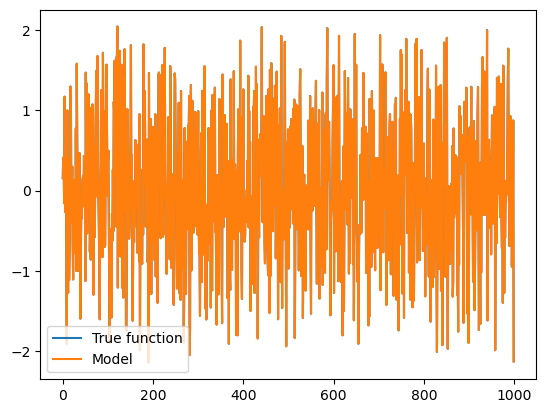

In [171]:
# 2D example
model = KANLayer(2, 1, 5, 2)

opt = torch.optim.Adam(model.parameters(), lr=0.01)

def f(x, y):
    return x + 1.2*y

data = torch.rand(1000, 2) * 2 - 1
labels = f(data[:, 0], data[:, 1])

for i in range(1000):
    opt.zero_grad()

    out = model(data)[:, 0]
    loss = (out - labels)**2
    loss = loss.mean()
    loss.backward()
    opt.step()

    if i % 100 == 0:
        print(f"Epoch {i}, loss: {loss.item()}")

plt.plot(labels, label="True function")
plt.plot(out.detach().numpy(), label="Model")

plt.legend()
plt.show()